In [1]:
%%time
import manager_dataset as MD
import question_processing as QP
import information_retrieval as IR
import named_entity_recognition as NER
import answer_processing as AP
from gensim.models import KeyedVectors
from util import util

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Wall time: 1min 32s


### Settings

Questions recive all the questions treated

In [2]:
questions = MD.questions(treated=True)
incosiderate_classes = ['X', 'MANNER', 'OBJECT', 'OTHER', 'DEFINITION']
questions = QP.remove_incosiderate_classes(questions, incosiderate_classes)  # Question with incosiderate class is removed

The questions that has an answer will be used for test while another questions will be used for train.

In [3]:
train_questions, test_questions = MD.split_questions(questions)

## Question Processing

### Question Classification

Or Load the Word2Vec model

In [ ]:
%%time
w2v_patch = 'data/word_embedding/cbow_s300.txt'
#w2v_patch = 'data/word_embedding/cbow_s50.txt'  # Fast test
w2v = KeyedVectors.load_word2vec_format(w2v_patch, unicode_errors="ignore")
model_w2v = {w: vec for w, vec in zip(w2v.index2word, w2v.syn0)}

And Train a SVM model

In [ ]:
%%time
qc_X_train, qc_y_train = QP.separete_questions(train_questions)

classifier = QP.svm_classifier()
vectorizer = QP.HybridVectorizer(model_w2v)
#vectorizer = QP.MeanEmbeddingVectorizer(model_w2v)
#vectorizer = QP.TfidfHybridVectorizer(model_w2v)
#vectorizer = QP.SequenceHybridVectorizer(model_w2v)
#vectorizer = QP.count_vectorizer(model_w2v)
#vectorizer = QP.tfidf_vectorizer(model_w2v)
model = QP.train_model(qc_X_train, qc_y_train, classifier, vectorizer)

Or Loading the the trained SVM model

In [4]:
%%time
import dill
model = dill.load(open(QP.answer_type_file, 'rb'))

Wall time: 54.7 s


Answer type is predicted for all questions

In [5]:
%%time
questions = QP.predict_answer_type(model, test_questions)

Wall time: 5.91 s


#### Testing

In [8]:
qc_X_test, qc_y_test = QP.separete_questions(test_questions)
print('Size train:',len(train_questions),'  Size test:',len(qc_y_test))

Size train: 1705   Size test: 644


Accuracy: 0.906832298137
F1 Score: 0.900166176246


<IPython.core.display.Javascript object>


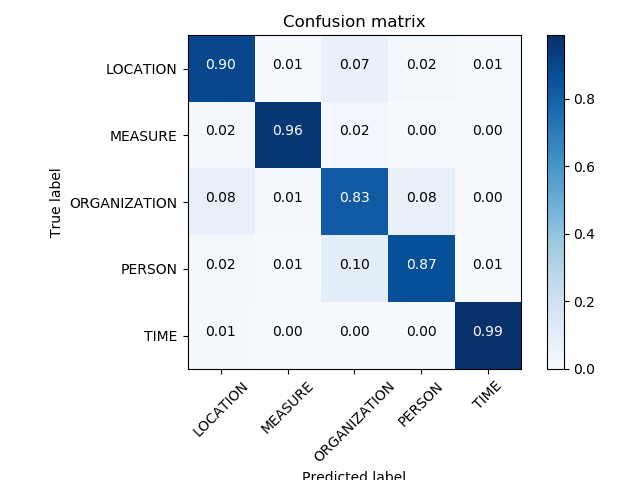

In [9]:
%matplotlib notebook
confusion_matrix = QP.testing(model, qc_X_test, qc_y_test)
QP.plot_confusion_matrix(confusion_matrix, ['LOCATION', 'MEASURE', 'ORGANIZATION', 'PERSON', 'TIME'], normalize=True)

### Query Formulation

All test questions will recive the query for IR module. 

In [27]:
test_questions = QP.queryFormulation(test_questions)

## Information Retrieval

### Document Retrieval

In [15]:
import information_retrieval as IR
ir = IR.InformationRetrieval()

Start the IR module. If the documents was not indexed then they will be.
When reset is True, all indexed documents is removed and indexed again.

In [16]:
ir.start(reset=False)

In [28]:
%%time
test_questions = ir.retrievalDocuments(test_questions)

[ . . . . . . . . . . ]
Wall time: 6.03 s


#### Testing

In [31]:
IR.test_ir_system(test_questions)

Precision: 0.060141509434
Recall: 0.492391060198
F-Score: 0.104694452329


### Named Entity Recognition

Train model

In [15]:
%%time
import named_entity_recognition as NER
model_ner = NER.train()

Wall time: 22.2 s


Or load model

In [19]:
%%time
import named_entity_recognition as NER
import dill
model_ner = dill.load(open(NER.file_ner, 'rb'))

Wall time: 217 ms


#### Testing

In [16]:
NER.predict(model_ner, u'No Brasil, mora o aluno Eduardo Cortes. Ele estuda na UFRGS em Porto Alegre')[0]

['O',
 'LOCAL-B',
 'O',
 'O',
 'O',
 'PESSOA-B',
 'PESSOA-I',
 'O',
 'O',
 'O',
 'ORGANIZACAO-B',
 'O',
 'LOCAL-B',
 'LOCAL-I']

### Passage Retrieval

In [32]:
%%time
test_questions = IR.retrievalPassagesQuestions(test_questions, model_ner, ir)

[ . . . . . . . . . . ]
Wall time: 1min 30s


## Answer Processing

### Answer Extraction

In [33]:
%%time
test_questions = AP.answer_candidates(test_questions, ir, model_ner)

[ . . . . . . . . . . ]
Wall time: 2.89 s


### Final Answer Selection

In [80]:
%%time
test_questions = AP.finals_answer(test_questions)

[ . . . . . . . . . . ]
Wall time: 221 ms


In [55]:
print(test_questions[0]['question'])
print(test_questions[0]['query'])
print(test_questions[0]['answers'])
for ac in test_questions[1]['answer_candidates']:
    print(float(("%0.1f"%ac['doc_rank'])), float(("%0.1f"%ac['votes'])), float(("%0.1f"%ac['score'])))


Em que cidade se encontra a prisão de San Vittore?
text:Em text:que text:cidade text:se text:encontra text:a text:prisão text:de text:San text:Vittore
[{'answer': '\nMilão\n', 'n': '2', 'doc': 'PUBLICO-19940724-039'}]
0.0 0.1 0.0
0.0 1.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.2 0.0
0.1 1.0 0.0
0.1 0.1 -0.1
0.1 0.0 -0.1
0.1 0.0 -0.1
0.1 0.0 -0.1
0.1 0.9 0.0
0.1 0.9 0.0
0.1 0.9 0.0
0.1 0.9 0.0
0.1 0.0 -0.1
0.1 0.1 -0.1
0.1 0.8 0.0
0.1 0.8 0.0
0.1 0.0 -0.1
0.1 0.0 -0.1
0.1 0.0 -0.1
0.1 0.8 0.0
0.1 0.8 0.0
0.1 0.7 0.0
0.1 0.7 0.0
0.2 0.7 0.0
0.2 0.1 -0.2
0.2 0.7 0.0
0.2 0.0 -0.2
0.2 0.0 -0.2
0.2 0.1 -0.2
0.2 0.1 -0.2
0.2 0.0 -0.2
0.2 0.6 0.0
0.2 0.0 -0.2
0.2 0.0 -0.2
0.2 0.0 -0.2
0.2 0.0 -0.2
0.2 0.0 -0.2
0.2 0.0 -0.2
0.2 0.0 -0.2
0.3 0.0 -0.3
0.3 0.0 -0.3
0.3 0.6 0.0
0.3 0.1 -0.3
0.3 0.6 0.0
0.3 0.0 -0.3
0.3 0.0 -0.3
0.3 0.6 0.0
0.3 0.0 -0.3
0.3 0.0 -0.3
0.3 0.1 -0.3
0.3 0.5 0.0
0.3 0.0 -0.3
0.3 0.0 -0.3
0.3 0.1 -0.3
0.3 0.5 0.0
0.3 0.1 -0.3
0.3 0.0 -0.3
0.3 0.0 -0.3
0.4 0.0 -0.4
0

#### Testing

Check if the answer_candidates have the right answer

In [81]:
AP.test_answer_candidates(test_questions)

644 / 375
Result: 58.230 %

Correct answer type:
584 / 352
Result: 60.274 %


## Final Evaluate

In [82]:
total = len(test_questions)
right = 0

cc_total = 0  # Total of question with correct candidates
cc_right = 0

for question in test_questions:
    aux = False
    if question['correct_answers_candidates']:
        aux = True
        cc_total += 1
    question['correct_final_answer'] = False
    for answer in question['answers']:
        if answer['answer'] is not None:
            a1 = answer['answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').strip()
            a2 = question['final_answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').strip()
            if a1 in a2 or a2 in a1:
                question['correct_final_answer'] = True
                right += 1
                if aux:
                    cc_right += 1
                break
print(str(total) + ' / ' + str(right))
print('Accuracy: '+ '%.3f' % ((right/total)*100)+' %')
print('\nCorrect answer candidates:\n' + str(cc_total) + ' / ' + str(cc_right))
print('Accuracy: '+ '%.3f' % ((cc_right/cc_total)*100)+' %')

644 / 107
Accuracy: 16.615 %

Correct answer candidates:
375 / 107
Accuracy: 28.533 %


Question Analysis

In [120]:
print('Q = Question\nSA = System Answer\nCA = Correct Answer(s)')


print('\n##### Correct Answers #####\n')
for i in range(len(test_questions)):
    if test_questions[i]['correct_final_answer']:
        print('Index: ' + str(i))
        print('Q: ' + test_questions[i]['question'])
        print('SA: ' + test_questions[i]['final_answer'])
        print('CA: ', end='')
        for answer in test_questions[i]['answers']:
            if answer['answer'] is not None:
                print(answer['answer'].strip(), end=' | ')
        print('\n')

print('\n##### Wrong Answers #####\n')
for i in range(len(test_questions)):
    if not test_questions[i]['correct_final_answer']:
        print('Index: ' + str(i))
        print('Q: ' + test_questions[i]['question'])
        print('SA: ' + test_questions[i]['final_answer'])
        print('CA: ', end='')
        for answer in test_questions[i]['answers']:
            if answer['answer'] is not None:
                print(answer['answer'].strip(), end=' | ')
        print('\n')

    


Q = Question
SA = System Answer
CA = Correct Answer(s)

##### Correct Answers #####

Index: 3
Q: Qual é a capital da Rússia?
SA: Moscovo
CA: Moscovo | 

Index: 6
Q: Quantos crimes são atribuídos ao Monstro de Florença?
SA: 16
CA: 16 assassinatos | 

Index: 18
Q: Onde fica o arquipélago de Svalbard?
SA: Noruega
CA: mais de mil quilómetros acima do Círculo Polar Árctico | junto à Noruega | Noruega | 800 quilómetros a norte do continente europeu | 

Index: 19
Q: Onde se realizou a Conferência Mundial da Mulher?
SA: Pequim
CA: China | Pequim | 

Index: 22
Q: Esmirna fica em que país?
SA: Turquia
CA: Turquia | 

Index: 26
Q: Em que cidade americana se encontra o Museu Warhol?
SA: Pittsburgh
CA: Pittsburgh | 

Index: 30
Q: Quem é o presidente da UEFA?
SA: Lennart Johansson
CA: Lennart Johansson | 

Index: 33
Q: Em que ano foi assassinado o presidente chileno Salvador Allende?
SA: 11 de Setembro de 1973
CA: 1973 | 

Index: 36
Q: Onde fica Hyde Park?
SA: Londres
CA: Londres | Nova Iorque | no 

SA: 4 de Julho
CA: 7 de Setembro | 

Index: 118
Q: Quando se tornou A Portuguesa hino nacional?
SA: Dezembro
CA: 5 de Outubro de 1910 | 

Index: 119
Q: Em que ano ocorreu o 25 de Abril?
SA: 1995
CA: 1974 | 

Index: 121
Q: Onde é que caiu um meteorito em 1908?
SA: Portugal
CA: Sibéria | Sibéria | 

Index: 123
Q: Indique um fabricante de automóveis alemão.
SA: Mercedes
CA: BMW | 

Index: 124
Q: Que partido foi fundado por Andrei Brejnev?
SA: União Soviética
CA: NIL | 

Index: 125
Q: Quem recebeu o Prémio Nobel da Paz em 1989?
SA: Miguel Delibes
CA: Dalai Lama | Tenzin | Dalai Lama | 

Index: 126
Q: Quem é o primeiro-ministro da Macedónia?
SA: Balcãs
CA: Branko Crvenkovski | 

Index: 127
Q: Quem fundou o partido ecologista colombiano Oxigénio?
SA: Rodriguez
CA: NIL | 

Index: 129
Q: Desde quando vive o Dalai Lama no exílio?
SA: 1989
CA: 1959 | 

Index: 131
Q: Quantas coffee shops existem nos Países-Baixos?
SA: 18
CA: 2400 | 

Index: 132
Q: Quantas pessoas vivem nas ilhas Aaland?
SA: 18
CA

Q: Em que museu foi exibida em 1994 uma exposição sobre Mondriaan?
SA: Brasil
CA: NIL | 

Index: 323
Q: Quando foram as Antilhas Holandesas legalmente equiparadas aos Países Baixos?
SA: 1946
CA: NIL | 

Index: 324
Q: Que país foi abalado por um terramoto em Agosto de 94?
SA: Japão
CA: Argélia | 

Index: 325
Q: O que é que foi anexado após a Guerra dos Seis Dias?
SA: 1945
CA: o sector árabe de Jerusálem | 

Index: 326
Q: Em que cidade é que fica o Roque Santeiro?
SA: São Paulo
CA: Luanda | 

Index: 327
Q: Em que estado fica Porto Alegre?
SA: Brasil
CA: Rio Grande do Sul | RS | 

Index: 328
Q: Onde fica Beslan?
SA: São Paulo
CA: Ossétia do Norte | 

Index: 329
Q: Onde fica a Grande Hanish?
SA: São Paulo
CA: mar Vermelho | 

Index: 330
Q: Onde fica o Banat?
SA: São Paulo
CA: Roménia | 

Index: 331
Q: Onde ganharam os Abba o Festival da Eurovisão?
SA: S Luiz
CA: Brighton | 

Index: 332
Q: Onde naufragou o Marika-7?
SA: Aveiro
CA: cerca de novecentos quilómetros a norte dos Açores | Atlânti

Q: Quem disse alea iacta est?
SA: R Madrid Esp
CA: Júlio César | 

Index: 531
Q: Ao atravessar que rio?
SA: Bósnia
CA: Rubicão | 

Index: 532
Q: Que político é conhecido como Iznogoud?
SA: PT
CA: Nicolas Sarkozy | 

Index: 533
Q: Qual a capital da Picardia?
SA: Paris
CA: Amiens | 

Index: 534
Q: Qual é a capital do estado de Nova York?
SA: Estados Unidos
CA: Albany | 

Index: 535
Q: Quais são as províncias da Irlanda?
SA: IRA
CA: Leinster, Munster, Connacht e Ulster. | 

Index: 536
Q: Que papa sucedeu a Leão X?
SA: D Manuel I
CA: Clement VII | 

Index: 537
Q: Que países abrange a Lapónia?
SA: Irlanda do Norte
CA: Noruega, Suécia, Finlândia e Federação Russa | 

Index: 538
Q: De que país é originário?
SA: Chuva de Estrelas
CA: Grécia | 

Index: 539
Q: Em que ano foi construída a sinagoga de Curação?
SA: 27
CA: 1732 | 

Index: 541
Q: Quem dirigiu o Japão durante a Segunda Guerra Mundial?
SA: Estados Unidos
CA: Hirohito | 

Index: 542
Q: Quantas repúblicas formavam a URSS?
SA: 40
CA: 15 |

In [ ]:
for c in test_questions[0]['answer_candidates']:
    print(c['score'], c['votes'])

In [ ]:
sorted(test_questions[0]['answer_candidates'], key=lambda k: k['score'])[-1]

## Util

### Detailed Question Analysis

In [57]:
question = {
    'question': u'Onde era o campo de concentração de Auschwitz?',
    'class': 'LOCATION'
}

question = test_questions[0]

print('Question: ' + question['question'])
print('Class: ' + question['class'])

# Question Classification
QP.predict_answer_type(model, [question])
print('Answer Type: ' + question['predict_class'])

# Query Formulation
QP.queryFormulation([question])
print('Query: ' + question['query'])

# Document Retrieval
ir.retrievalDocuments([question])
print('Number of retrieval documents: ' + str(len(question['retrieval'])))

# Passages Retrieval
IR.retrievalPassagesQuestions([question], model_ner, ir)

# Answers Candidates
AP.answer_candidates([question], QP, ir, NER, model_ner)
print('Number of answer candidates: ' + str(len(question['answer_candidates'])))

# Final Answer
AP.finals_answer([question])
print('Answer: ' + question['final_answer'])

if 'answers' in question:
    print('Correct Answers: ', end='')
    for answer in question['answers']:
        if answer['answer'] is not None:
            print(answer['answer'].strip(), end=' | ')

Question: Em que cidade se encontra a prisão de San Vittore?
Class: LOCATION
Answer Type: LOCATION
Query: text:Em text:que text:cidade text:se text:encontra text:a text:prisão text:de text:San text:Vittore
[ . ]
Number of retrieval documents: 10
[ . ]
[ . ]
Number of answer candidates: 115
[ . ]
Answer: Itália
Correct Answers: Milão | 

Show documents id

In [ ]:
print('Retrieval Documents ID: ', end='')
for doc_id in question['retrieval']:
    print(doc_id, end=', ')

if 'answers' in question:
    print('\n\nRelevants Documents ID: ', end='')
    for answer in question['answers']:
        if answer['doc'] is not None and len(answer['doc']) > 0:
            print(answer['doc'], end=', ')

Show documents texts

In [ ]:
for doc_id in question['retrieval']:
    print('\n'+doc_id+'\n'+ir.documentText(doc_id))

In [ ]:
doc_id = 'PUBLICO-19940929-035'
print('\n'+doc_id+'\n'+ir.documentText(doc_id))

Show answers candidates

In [ ]:
for ac in question['answer_candidates']:
    print(ac['full_answer'])

Show most vote answer candidates

In [75]:
import operator
votes = {}
for candidate in question['answer_candidates']:
    if candidate['full_answer'].lower() not in question['question'].lower():
        if candidate['full_answer'] not in votes:
            votes[candidate['full_answer']] = candidate['score']
[(k, votes[k]) for k in sorted(votes, key=votes.get, reverse=True)]

[('Modigliani', 0.8),
 ('Paris', 0.45714285714285713),
 ('Itália', 0.22857142857142856),
 ('Lisboa', 0.11428571428571428),
 ('Saló', 0.05178571428571428),
 ('Colónia', 0.041071428571428564),
 ('Veneza', 0.041071428571428564),
 ('Souza-Cardoso', 0.0),
 ('Leixões', -0.010714285714285718),
 ('São Paulo', -0.04285714285714287),
 ('Santo Domingo', -0.0625),
 ('Mussolini', -0.0625),
 ('Milão', -0.0625),
 ('América Latina', -0.0625),
 ('Leça da Palmeira', -0.125),
 ('Málaga Portoferrairo', -0.125),
 ('Outubro', -0.125),
 ('Amerigo Vespucci', -0.125),
 ('Portugal', -0.13571428571428573),
 ('Turim', -0.13571428571428573),
 ('Bona', -0.1875),
 ('Colónia de 448', -0.1875),
 ('Alemanha Colónia', -0.1875),
 ('Rue du Delta', -0.1875),
 ('Musée', -0.1875),
 ('Trocadero', -0.1875),
 ('Hollywood', -0.19821428571428573),
 ('Diário de Notícias', -0.25),
 ('Marchas de Lisboa', -0.25),
 ('Santa Catarina', -0.25),
 ('Itália do Quatrocento', -0.25),
 ('Oficina', -0.25),
 ('Toscana', -0.25),
 ('Niblo', -0.312

In [66]:
for x in sorted(question['answer_candidates'], key=lambda k: k['score'])[::-1]:
    print(float(("%0.2f"%x['doc_rank'])), float(("%0.2f"%x['votes'])), float(("%0.2f"%x['score'])))  

0.0 1.0 0.1
0.0 0.9 0.09
0.0 0.8 0.08
0.0 0.7 0.07
0.0 0.6 0.06
0.0 0.6 0.06
0.0 0.5 0.05
0.0 0.5 0.05
0.0 0.4 0.04
0.0 0.4 0.04
0.0 0.3 0.03
0.0 0.3 0.03
0.0 0.2 0.02
0.0 0.2 0.02
0.0 0.1 0.01
0.0 0.1 0.01
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.11 0.2 -0.09
0.11 0.1 -0.1
0.11 0.0 -0.11
0.11 0.0 -0.11
0.11 0.0 -0.11
0.11 0.0 -0.11
0.11 0.0 -0.11
0.22 0.2 -0.2
0.22 0.1 -0.21
0.22 0.1 -0.21
0.22 0.1 -0.21
0.22 0.1 -0.21
0.22 0.0 -0.22
0.22 0.0 -0.22
0.22 0.0 -0.22
0.22 0.0 -0.22
0.22 0.0 -0.22
0.22 0.0 -0.22
0.22 0.0 -0.22
0.22 0.0 -0.22
0.33 0.1 -0.32
0.33 0.1 -0.32
0.33 0.0 -0.33
0.33 0.0 -0.33
0.33 0.0 -0.33
0.33 0.0 -0.33
0.33 0.0 -0.33
0.33 0.0 -0.33
0.33 0.0 -0.33
0.33 0.0 -0.33
0.33 0.0 -0.33
0.44 0.0 -0.44
0.44 0.0 -0.44
0.44 0.0 -0.44
0.44 0.0 -0.44
0.44 0.0 -0.44
0.44 0.0 -0.44
0.44 0.0 -0.44
0.44 0.0 -0.44
0.56 0.2 -0.54
0.56 0.1 -0.55
0.56 0.1 -0.55
0.56 0.0 -0.56
0.56 0.0 -0.56
0.5

In [ ]:
NER.predict(model_ner, u'Tradução para chinês do Ulisses, de James Joyce.')[0]

### Others

In [ ]:
ir.stop()

In [79]:
import importlib
importlib.reload(AP)
#raise IpyExit

<module 'answer_processing' from 'C:\\Users\\Eduardo\\UFRGS\\QA\\qa-chave\\answer_processing.py'>